<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of IPLA to the Bayesian neural network considered in Section 3.2 of [Particle algorithms for maximum likelihood training of latent
variable models](https://juankuntz.github.io/publication/parem/). IPLA dismiss the non-differentiability of our target distribution

# Figure 4

First, we load the modules we need:

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [24]:
#@title Load, subsample, and normalize MNIST dataset.

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries (pixels across whole dataset) so that they have mean zero 
# and unit standard across the dataset:
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

In [3]:
#@title Implement algorithms.

# Algorithms.
from tqdm import tqdm

def pgd(ltrain, itrain, ltest, itest, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    # Initialize arrays storing performance metrics as a function of k:
    lppd = np.zeros(K)  # Log pointwise predictive density (LPPD).
    error = np.zeros(K)  # Test error.

    for k in (tqdm(range(K))):
        # Evaluate metrics for current particle cloud:
        lppd[k] = log_pointwise_predrictive_density(w, v, itest, ltest)
        error[k] = test_error(w, v, itest, ltest)

        # Temporarily store current particle cloud:
        wk = w  # Input layer weights.
        vk = v  # Output layer weights.

        # Update parameter estimates 
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])/Dv)  # Beta.

        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v, lppd, error


def ipla(ltrain, itrain, ltest, itest, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.
    N = w.shape[-1]

    # Initialize arrays storing performance metrics as a function of k:
    lppd = np.zeros(K)  # Log pointwise predictive density (LPPD).
    error = np.zeros(K)  # Test error.

    for k in (tqdm(range(K))):
        # Evaluate metrics for current particle cloud:
        lppd[k] = log_pointwise_predrictive_density(w, v, itest, ltest)
        error[k] = test_error(w, v, itest, ltest)

        # Temporarily store current particle cloud:
        wk = w  # Input layer weights.
        vk = v  # Output layer weights.

        # Update parameter estimates 
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])/Dw + jnp.sqrt(2*h/N)*np.random.normal(0, 1, 1))  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])/Dv + jnp.sqrt(2*h/N)*np.random.normal(0, 1, 1))  # Beta.

        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v, lppd, error


# Auxiliary functions.

# Functions for the log density.

def _log_nn(w, v, image):
    # Log of the network's output when evaluated at image with weights w, v.
    arg = jnp.dot(v, jnp.tanh(jnp.dot(w, image.reshape((28**2)))))
    return jax.nn.log_softmax(arg)


def _log_nn_vec(w, v, images):
    # _log_nn vectorized over particles.
    return jax.vmap(_log_nn, in_axes=(None, None, 0))(w, v, images)


def _log_prior(x, lsig):
    # Log of a Gaussian prior, with mean 0 and variance e^lsig, evaluated at x.
    v = x.reshape((x.size))
    sig = jnp.exp(lsig)
    return -jnp.sum(jnp.abs(v))/(sig**2) - x.size * (jnp.log(2) + 2* lsig)


def _log_likelihood(w, v, images, labels):
    # Log-likelihood for set of images and labels, vectorized over particles.
    return (_log_nn_vec(w, v, images)[jnp.arange(labels.size), labels]).sum()


def _log_density(w, v, a, b, images, labels):
    # Log of model density, vectorized over particles.
    out = _log_prior(w, a) + _log_prior(v, b)
    return out + _log_likelihood(w, v, images, labels)


# Functions for the gradients of the log-density.'

def _grad_param(x, lsig):
    # Parameter gradient of one of the two log-priors.
    grad = jax.grad(_log_prior, argnums=1)
    return grad(x, lsig)


@jax.jit
def ave_grad_param(w, lsig):
    """Parameter gradient averaged over particle cloud."""
    grad_a = jax.grad(_log_prior, argnums=1)
    grad = jax.vmap(grad_a, in_axes=(2, None))(w, lsig)
    return grad.mean()


@jax.jit
def wgrad(w, v, a, b, images, labels):
    """w-gradient vectorized over particle cloud."""
    grad = jax.grad(_log_density, argnums=0)
    gradv = jax.vmap(grad, in_axes=(2, 2, None, None, None, None), out_axes=2)
    return gradv(w, v, a, b, images, labels)


@jax.jit
def vgrad(w, v, a, b, images, labels):
    """v-gradients vectorized over particle cloud."""
    grad = jax.grad(_log_density, argnums=1)
    gradv = jax.vmap(grad, in_axes=(2, 2, None, None, None, None), out_axes=2)
    return gradv(w, v, a, b, images, labels)


# Functions for the negative Hessian of the log prior used in the PQN update.

def _neg_hess_param(x, lsig):
    # Negative parameter Hessian of one of the two log-priors.'
    v = x.reshape((x.size))
    sig = jnp.exp(lsig)
    return 2*jnp.dot(v, v)/(sig**2)


@jax.jit
def ave_neg_hess_param(w, lsig):
    """Negative parameter Hessian averaged over particles."""
    hess = jax.vmap(_neg_hess_param, in_axes=(2, None))(w, lsig)
    return hess.mean()


# Functions for the optimal parameters used in the PMGD update.

def _normsq(x):
    # Squared Frobenius norm of x.
    v = x.reshape((x.size))
    return jnp.dot(v, v)


@jax.jit
def optimal_param(w):
    """Optimal parameter for weight cloud w."""
    mom2 = (jax.vmap(_normsq, in_axes=(2))(w)).mean()  # Second moment
    return jnp.log(mom2/(w[:, :, 0].size))/2


# Functions for the performance metrics.

def _nn(w, v, image):
    # Network's output when evaluated at image with weights w, v.
    arg = jnp.dot(v, jnp.tanh(jnp.dot(w, image.reshape((28**2)))))
    return jax.nn.softmax(arg)


def _nn_vec(w, v, images):
    # _nn vectorized over images.
    return jax.vmap(_nn, in_axes=(None, None, 0))(w, v, images)


def _nn_vec_vec(w, v, images):
    # _nn_vec vectorized over particles.
    return jax.vmap(_nn_vec, in_axes=(2, 2, None), out_axes=2)(w, v, images)


@jax.jit
def log_pointwise_predrictive_density(w, v, images, labels):
    """Returns LPPD for set of (test) images and labels."""
    s = _nn_vec_vec(w, v, images).mean(2)
    return jnp.log(s[jnp.arange(labels.size), labels]).mean()


def _predict(w, v, images):
    # Returns label maximizing the approximate posterior predictive 
    # distribution defined by the cloud (w,v), vectorized over images.
    s = _nn_vec_vec(w, v, images).mean(2)
    return jnp.argmax(s, axis=1)


@jax.jit
def test_error(w, v, images, labels):
    """Returns fraction of misclassified images in test set."""
    return jnp.abs(labels - _predict(w, v, images)).mean()

We can now run the algorithms using an 80/20 training/test split of the data:

We run the model using IPLA with a Laplace prior on the weights ignoring the points of discontinuity

In [70]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 250  # Number of steps.
N = 50  # Number of particles.

# Initialize parameter estimates:
a0 = np.array([0.1])  # Alpha.
b0 = np.array([0.1])  # Beta.

# Initialize particle cloud by sampling prior:'
w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # Input layer weights.
v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # Output layer weights.

# Run algorithms:
a_pgd, b_pgd, w_pgd, v_pgd, lppd_pgd, error_pgd = ipla(ltrain, itrain, ltest, 
                                                      itest, h, K, a0, b0, w0, 
                                                      v0)

100%|██████████| 250/250 [00:19<00:00, 12.99it/s]


In [27]:
print(lppd_pgd[-1], error_pgd[-1])

-0.09608747065067291 0.014999999664723873


In [71]:
data = np.array(w_pgd[:, :, -1].ravel().tolist())
print(np.std(data))

10.521934166704431


As a sanity check, we plot the test error throughout training:

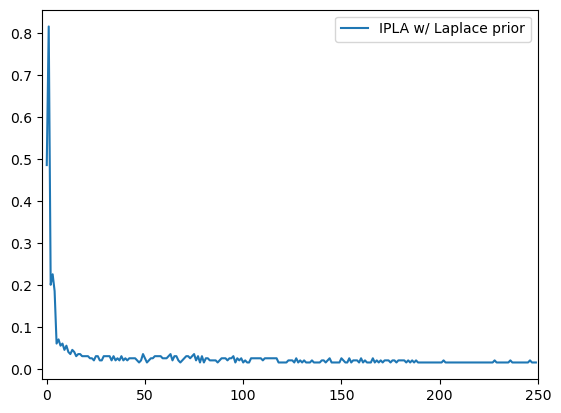

In [8]:
plt.plot(error_pgd, label='IPLA w/ Laplace prior') 
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

As expected, the error decreases during training for all four algorithms. PGD, PQN, PMGD achieve noticeably smaller errors:

(-2.5, 250.0)

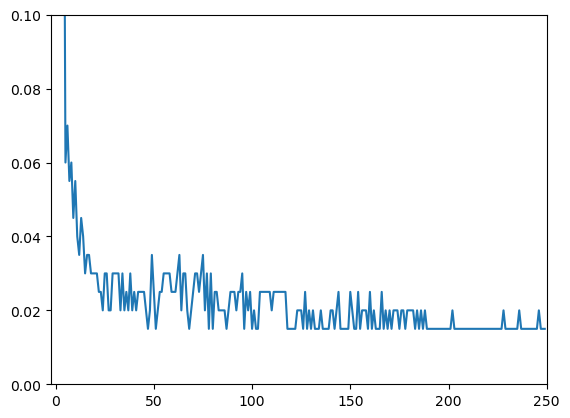

In [9]:
plt.plot(error_pgd, label='IPLA w/ Laplace prior') 
plt.ylim([0, 0.1])
plt.xlim([-K/100, K])

The parameter estimates seem to converge to various local optima:

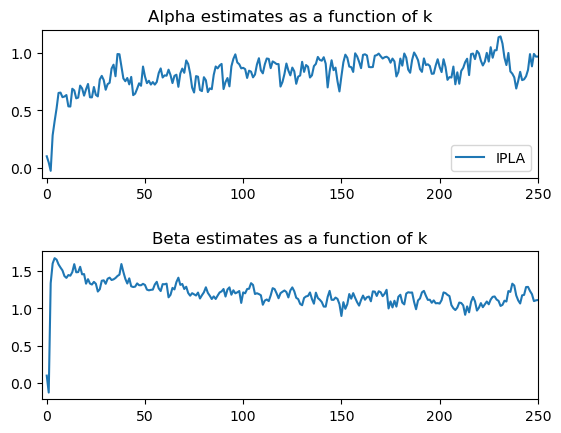

In [10]:
plt.subplot(2, 1, 1)
plt.plot(a_pgd, label='IPLA') 
plt.title('Alpha estimates as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(b_pgd, label='IPLA') 
plt.title('Beta estimates as a function of k')
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

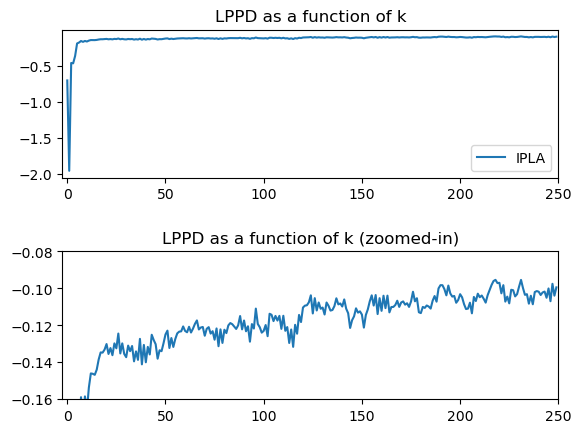

In [12]:
plt.subplot(2, 1, 1)
plt.plot(lppd_pgd, label='IPLA') 
plt.title('LPPD as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(lppd_pgd, label='IPLA') 
plt.title('LPPD as a function of k (zoomed-in)')
plt.ylim([-0.16, -0.08])
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

#### Analyse sparsity of weights

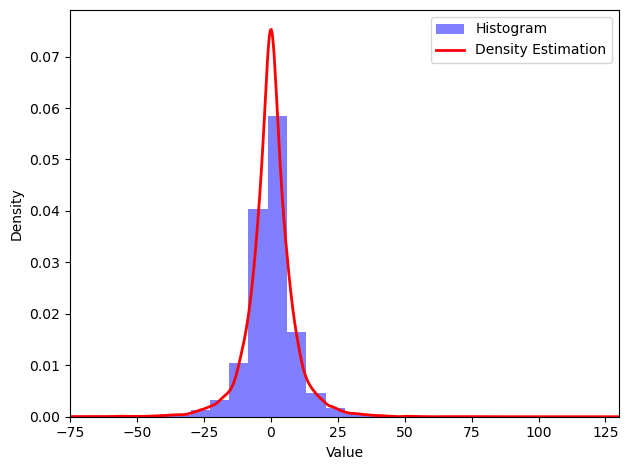

In [77]:
from scipy.stats import gaussian_kde

fig = plt.figure()

#data = np.array(np.mean(w_pgd, axis=2).flatten().tolist())
data = np.array(w_pgd[:, :, -15].ravel().tolist())
#data = w_pgd[:, :, -10].flatten()

# Prior distribution samples
data2 = np.random.laplace(0, 1, 1000)

# Step 2: Plot a Histogram
plt.hist(data, bins=50, density=True, alpha=0.5, color='b', label='Histogram')

# Step 3: Perform Density Estimation
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)
#x_vals = np.linspace(-67, 125, 1000)
density_estimation = kde.evaluate(x_vals)

kde_2 = gaussian_kde(data2)
x_vals_2 = np.linspace(min(data), max(data), 1000)
density_estimation_2 = kde_2.evaluate(x_vals_2)

# Step 4: Plot the Density Estimation
plt.plot(x_vals, density_estimation, 'r-', linewidth=2, label='Density Estimation')

# Adding labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
#plt.title('Histogram and Density Estimation')
plt.legend()
plt.xlim(-75, 130)
# Show the plots
plt.tight_layout()
plt.show()